**Homework 2: Single-cell sketching algorithms**


*   This homework assignment is due Friday, April 18 at 11:59pm.
*   Please submit homework as a PDF in Canvas. Homework will only be accepted in PDF format
* You can copy this notebook to your own notebook and run all of the code, but please do write up your solution in its own document.
*   This homework is worth 20 points total.








Step 1: Please install and import the following packages

In [ ]:
!pip install matplotlib==3.6.2 scanpy==1.8.0 scprep==1.1.0 numpy==1.25.2 pandas==1.5.3 fbpca geosketch

In [ ]:
import scanpy as sc
import scprep
import pandas as pd
import anndata
import numpy as np
import geosketch

/usr/local/lib/python3.11/dist-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/anndata/utils.py:434: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/u

Step 2: Load the fibroblast data. You can read more about this dataset here, https://www.nature.com/articles/nature18323

In [ ]:
scprep.io.download.download_google_drive(id = "1P7poq_IHfCjcr1iLtUgPDpWbw3zQtJ4E", destination = 'fibroblast_expression.csv')
scprep.io.download.download_google_drive(id = "1DQf0wYA7DEaTnTPf11Mj-TSyAxtUcqHb", destination = 'fibroblast_metadata.csv')
fibroblast_data = pd.read_csv('fibroblast_expression.csv', index_col = 0)
fibroblast_metadata = pd.read_csv('fibroblast_metadata.csv', index_col = 0)

Step 3: We will run geometric sketching (Hie et al., Cell Systems) on a dimension-reduced version of the data. In this example, 200 cells will be sketched. The code shows you how to visualize the original and sketched versions of the data.




(355, 100)
AnnData object with n_obs × n_vars = 355 × 2000
    obs: 'cell_labels', 'timepoint'
AnnData object with n_obs × n_vars = 200 × 2000
    obs: 'cell_labels', 'timepoint'


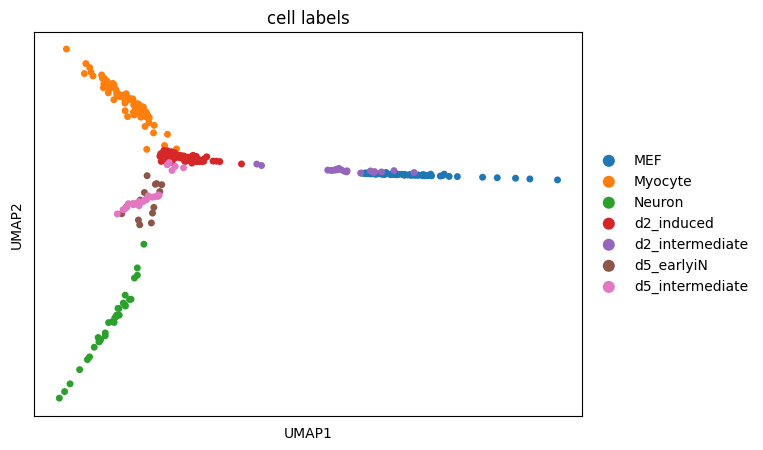

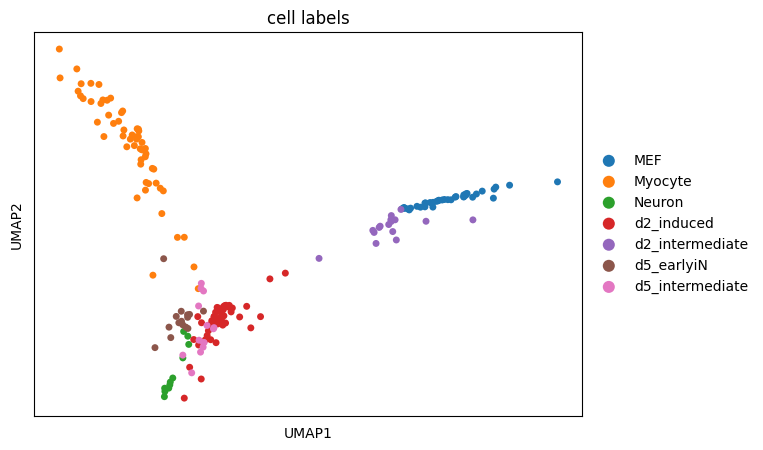

1_iN1_C01                    d2_induced
1_iN1_C02                    d2_induced
1_iN1_C03                    d2_induced
1_iN1_C04               d2_intermediate
1_iN1_C05               d2_intermediate
                             ...       
714_506_1g_22d1_C54             Myocyte
714_507_1g_22d1_C60             Myocyte
714_508_1g_22d1_C72             Myocyte
715_506_1gg_22d2_C72            Myocyte
715_507_1gg_22d2_C76            Myocyte
Name: cell_labels, Length: 355, dtype: category
Categories (7, object): ['MEF', 'Myocyte', 'Neuron', 'd2_induced', 'd2_intermediate',
                         'd5_earlyiN', 'd5_intermediate']


In [ ]:
from fbpca import pca

#preparing fibroblast data for PCA
X = fibroblast_data.iloc[:,1:]
X = X.to_numpy()

#apply dimension reduction for sketching pre-processing
U, s, Vt = pca(X, k=100) # E.g., 100 dimensions.
X_dimred = U[:, :100] * s[:100]
print(np.shape(X_dimred))

#apply geometric sketching
from geosketch import gs
N = 200 # Number of sketched cells to obtain.
sketch_index = gs(X_dimred, N, replace=False) #gives you indices of cells chosen in the sketch

#create annData object for the entire fibroblast dataset (e.g. data structure for single-cell)
adata_fibroblast = anndata.AnnData(fibroblast_data) #create AnnData object
adata_fibroblast.obs = fibroblast_metadata #append metadata as observation

#get the sketched annData object (e.g. subset of the original dataset according to cells that were sketched)
adata_sketch = adata_fibroblast[sketch_index, :].copy()

print(adata_fibroblast)
print(adata_sketch)

#visualize UMAPs of sketched and original datasets to see what is happening

#####
#original
#####
sc.pp.pca(adata_fibroblast, n_comps=50)
sc.pp.neighbors(adata_fibroblast, n_neighbors= 10)
sc.tl.umap(adata_fibroblast)
sc.pl.scatter(adata_fibroblast, basis = 'umap', color = 'cell_labels', size = 100)

#####
#sketched
#####

sc.pp.pca(adata_sketch, n_comps=50)
sc.pp.neighbors(adata_sketch, n_neighbors= 10)
sc.tl.umap(adata_sketch)
sc.pl.scatter(adata_sketch, basis = 'umap', color = 'cell_labels', size = 100)

#example of how to access cell-to-label assignments
cell_labels = adata_fibroblast.obs['cell_labels']
print(cell_labels)


# **Problem 1** : Running the code above (5 points)
Run the code above to compute a sketch with 200 cells from the fibroblast dataset. Include UMAP visualizations of the original and sketched versions of the dataset.  

# **Problem 2** : Computing frequencies of the original and sketched versions of the fibroblast data (5 points).
Recall that we can use frequency features to evaluate if a sketch is preserving information from the original data. Frequency features are defined as the fraction of cells assigned to each cell-type. From the code above, we see that we can access cell-type labels in the fibroblast anndata object as,

> cell_labels = adata_fibroblast.obs['cell_labels']

Compute the frequencies of cells across all cell-types in the original fibroblast dataset (so, using adata_fibroblast for the original dataset and adata_sketch for the sketched version of the data). Since there are 7 cell-types, this will give a vector of length 7 for each annData (adata_fibroblast and adata_sketch) object. Compute the pearson correlation between the frequency vectors between the original and sketched versions of the data.



# **Problem 3: Examining frequencies of cell-types as a function of sketch size (5 points)**
In problem 2, you computed frequencies based on a sketch size of 200 cells. Compute sketches of size 25, 50, 100, 125, 150, and 200 and plot the pearson correlation between the frequencies obtained for each of these sketches with the frequencies obtained using the full dataset. Plot these correlations as a function of sketch size and comment on any patterns you observe.

# **Problem 4: Compare to sketching with random sampling (5 points)**
Instead of using geometric sketching, we can simply compute sketches by sampling a random subset of cells (without replacement). Repeat problem 3 to generate sketches of size 25, 50, 100, 125, 150, and 200 through random sampling. Examine correlations between the frequencies obtained with these sketches in the frequencies in the origial data and plot correlation again as a function on sketch size. Discuss any differences that you observed between geometric sketching and random sampling.   